## Modeling

*This notebook contains first modeling approach - its implementation, testing and evaluation. Background noise is not taken into account here, just preprocessing of the files is conducted. Final modeling approach can be found in modeling-experiments.ipynb notebook.*

In [53]:
import os
import numpy as np
from scipy.fftpack import fft
from scipy.io import wavfile
from scipy import signal
from glob import glob
import pandas as pd
import gc
from scipy.io import wavfile
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from keras import optimizers, losses, activations, models
from keras.layers import Dense, Input, Dropout, BatchNormalization
import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Conv1D, GRU
from tensorflow.keras.layers import Input, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix

In [3]:
# data
data_path = './../data/train/audio'
labels = os.listdir(data_path)
classes = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go'] 

SAMPLING_RATE = 16000

In [4]:
# train-val-test split files
validation_list = pd.read_csv('./../data/train/validation_list.txt', sep="\t", header=None)[0].tolist()
testing_list = pd.read_csv('./../data/train/testing_list.txt', sep="\t", header=None)[0].tolist()

In [5]:
print('Training: ', 64721 - len(validation_list) - len(testing_list))
print('Validation: ', len(validation_list))
print('Testing: ', len(testing_list))

Training:  51088
Validation:  6798
Testing:  6835


In [6]:
# audio preprocessing functions
def pad_audio(samples):
    return np.pad(samples, pad_width=(SAMPLING_RATE - len(samples), 0), mode='constant', constant_values=(0, 0))

def chop_audio(samples):
    return samples[:SAMPLING_RATE]

def label_transform(labels):
    new_labels = []
    for label in labels:
        if label not in classes:
            new_labels.append('unknown')
        else:
            new_labels.append(label)
    return pd.get_dummies(pd.Series(new_labels))

def specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    _, _, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return np.log(spec.T.astype(np.float32) + eps)

In [24]:
def plot_model_history(history, title: str) -> None:
    """
    Plotting the learning curve of Keras model, broken down into loss curve and accuracy curve, 
    for both training and validation data.

    Args:
        history : Object returned by the .fit method of Keras model.
        title (str): Title of the plots.
    """
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    fig.suptitle(title, size=15)
    plt.show()

In [8]:
# train-val-test split
train_labels = []
train_specgrams = []
val_labels = []
val_specgrams = []
test_labels = []
test_specgrams = []

for label in [l for l in labels if l != '_background_noise_']:
    print(label)
    files = [f for f in os.listdir(data_path + '/'+ label) if f.endswith('.wav')]
    
    for file in files:
        sample_rate, samples = wavfile.read(data_path + "/" + label + "/" + file)
        if sample_rate != SAMPLING_RATE: print('wrong')
        duration = float(len(samples)/sample_rate)
        
        if duration < 1: samples = pad_audio(samples)
        elif duration > 1: samples = chop_audio(samples)
            
        if (label + "/" + file) in validation_list: 
            val_labels.append(label)
            val_specgrams.append(specgram(samples, SAMPLING_RATE))
        elif (label + "/" + file) in testing_list: 
            test_labels.append(label)
            test_specgrams.append(specgram(samples, SAMPLING_RATE))
        else:
            train_labels.append(label)
            train_specgrams.append(specgram(samples, SAMPLING_RATE))

bed
bird
cat
dog
down
eight
five
four
go
happy
house
left
marvin
nine
no
off
on
one
right
seven
sheila
six
stop
three
tree
two
up
wow
yes
zero


In [9]:
# label encoding
x_train = np.array(train_specgrams)
x_val = np.array(val_specgrams)
x_test = np.array(test_specgrams)

del train_specgrams, val_specgrams, test_specgrams
y_train = label_transform(train_labels)
y_val = label_transform(val_labels)
y_test = label_transform(test_labels)

y_train = np.array(y_train.values)
y_val = np.array(y_val.values)
y_test = np.array(y_test.values)

del train_labels, val_labels, test_labels
gc.collect()

225

In [37]:
# background noise
noise_files = [f for f in os.listdir(data_path + '/_background_noise_') if f.endswith('.wav')]
noise_durations = []
for nf in noise_files:
    sample_rate, samples = wavfile.read(data_path + '/_background_noise_/' + nf)
    noise_durations.append(float(len(samples)/sample_rate))
noise_durations

C:\Users\agama\AppData\Local\Temp\ipykernel_628\3085253686.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, samples = wavfile.read(data_path + '/_background_noise_/' + nf)


[95.183125, 61.8056875, 61.253875, 60.0, 61.1555, 60.0]

In [46]:
# converting the files into samples of 1 sec each
noise_sampled = []
for nf in noise_files:
    sample_rate, samples = wavfile.read(data_path + '/_background_noise_/' + nf)
    mins = int(len(samples)/sample_rate)
    for i in range(mins - 1):
        sample = samples[i*sample_rate:(i+1)*sample_rate]
        noise_sampled.append(sample)
noise_data =  np.zeros((len(noise_sampled), sample_rate))
for i, d in enumerate(noise_sampled):
    noise_data[i] = d
print(noise_data.shape)

(392, 16000)


C:\Users\agama\AppData\Local\Temp\ipykernel_628\3056645728.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, samples = wavfile.read(data_path + '/_background_noise_/' + nf)


## Modeling

In [10]:
# hyperparameters set-up
INPUT_DIM = (x_train.shape[1], x_train.shape[2])
OUTPUT_DIM = len(classes) + 1 

BATCH_SIZE = 128
EPOCHS = 30
LR = 1e-4
DROPOUT = 0.2
OPT = Adam(learning_rate=LR, clipnorm=1.0) 

In [11]:
def rnn_network(input_dim, output_dim, rnn_layer):

    input_data = Input(name='input', shape=input_dim, dtype='float32')

    x = Conv1D(filters=256, kernel_size=10, strides=4, name='conv1d')(input_data)
    x = BatchNormalization(name='b_norm')(x)
    x = Activation('relu', name='activation')(x)
    x = Dropout(DROPOUT, name='dropout_1')(x)
    x = rnn_layer(128, activation='relu', return_sequences=True, dropout=DROPOUT, name='rnn_1')(x)
    x = rnn_layer(128, activation='relu', return_sequences=False, dropout=DROPOUT, name='rnn_2')(x)
    x = Dense(units=64, activation='relu', name='dense')(x)
    x = Dropout(DROPOUT, name='dropout_2')(x)

    output_data = Dense(units=output_dim, activation='softmax', name='softmax')(x)

    model = Model(inputs=input_data, outputs=output_data, name=str(rnn_layer).split(".")[-1].split("'")[0])
    model.compile(loss='categorical_crossentropy', optimizer=OPT, metrics=['accuracy'])

    return model

### SimpleRNN

In [15]:
model_simple = rnn_network(INPUT_DIM, OUTPUT_DIM, SimpleRNN)
model_simple.summary()

Model: "SimpleRNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 99, 161)]         0         
                                                                 
 conv1d (Conv1D)             (None, 23, 256)           412416    
                                                                 
 b_norm (BatchNormalization)  (None, 23, 256)          1024      
                                                                 
 activation (Activation)     (None, 23, 256)           0         
                                                                 
 dropout_1 (Dropout)         (None, 23, 256)           0         
                                                                 
 rnn_1 (SimpleRNN)           (None, 23, 128)           49280     
                                                                 
 rnn_2 (SimpleRNN)           (None, 128)               32

In [16]:
K.clear_session()

In [17]:
history_simple = model_simple.fit(x_train, y_train,
                                  batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,
                                  validation_data=(x_val, y_val),
                       )

Epoch 1/30
400/400 [==============================] - 151s 348ms/step - loss: 1.3865 - accuracy: 0.6307 - val_loss: 1.2660 - val_accuracy: 0.6208
Epoch 2/30
400/400 [==============================] - 160s 401ms/step - loss: 1.1853 - accuracy: 0.6416 - val_loss: 1.0343 - val_accuracy: 0.6523
Epoch 3/30
400/400 [==============================] - 150s 375ms/step - loss: 1.0234 - accuracy: 0.6674 - val_loss: 0.9333 - val_accuracy: 0.6849
Epoch 4/30
400/400 [==============================] - 158s 395ms/step - loss: 0.9032 - accuracy: 0.6957 - val_loss: 0.7843 - val_accuracy: 0.7333
Epoch 5/30
400/400 [==============================] - 151s 377ms/step - loss: 0.7802 - accuracy: 0.7392 - val_loss: 0.6525 - val_accuracy: 0.7816
Epoch 6/30
400/400 [==============================] - 168s 420ms/step - loss: 0.6634 - accuracy: 0.7818 - val_loss: 0.5433 - val_accuracy: 0.8189
Epoch 7/30
400/400 [==============================] - 167s 417ms/step - loss: 0.5591 - accuracy: 0.8146 - val_loss: 0.4605 -

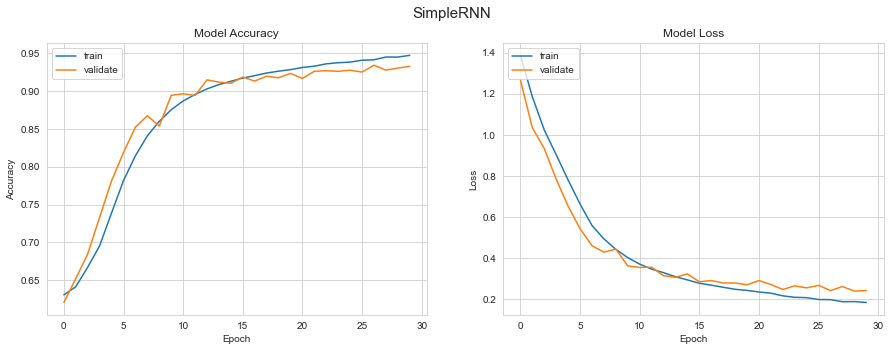

In [27]:
plot_model_history(history_simple, 'SimpleRNN')

### LSTM

In [18]:
model_lstm = rnn_network(INPUT_DIM, OUTPUT_DIM, LSTM)
model_lstm.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 99, 161)]         0         
                                                                 
 conv1d (Conv1D)             (None, 23, 256)           412416    
                                                                 
 b_norm (BatchNormalization)  (None, 23, 256)          1024      
                                                                 
 activation (Activation)     (None, 23, 256)           0         
                                                                 
 dropout_1 (Dropout)         (None, 23, 256)           0         
                                                                 
 rnn_1 (LSTM)                (None, 23, 128)           197120    
                                                                 
 rnn_2 (LSTM)                (None, 128)               131584 

In [19]:
K.clear_session()

In [20]:
history_lstm = model_lstm.fit(x_train, y_train,
                              batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,
                              validation_data=(x_val, y_val),
                       )

Epoch 1/30
400/400 [==============================] - 122s 284ms/step - loss: 1.1197 - accuracy: 0.6718 - val_loss: 0.7694 - val_accuracy: 0.7533
Epoch 2/30
400/400 [==============================] - 107s 267ms/step - loss: 0.6414 - accuracy: 0.7920 - val_loss: 0.5016 - val_accuracy: 0.8404
Epoch 3/30
400/400 [==============================] - 110s 274ms/step - loss: 0.4634 - accuracy: 0.8534 - val_loss: 0.3882 - val_accuracy: 0.8789
Epoch 4/30
400/400 [==============================] - 110s 276ms/step - loss: 0.3808 - accuracy: 0.8816 - val_loss: 0.3591 - val_accuracy: 0.8882
Epoch 5/30
400/400 [==============================] - 110s 275ms/step - loss: 0.3304 - accuracy: 0.8985 - val_loss: 0.3452 - val_accuracy: 0.8947
Epoch 6/30
400/400 [==============================] - 113s 282ms/step - loss: 0.2967 - accuracy: 0.9092 - val_loss: 0.3257 - val_accuracy: 0.8997
Epoch 7/30
400/400 [==============================] - 113s 283ms/step - loss: 0.2721 - accuracy: 0.9154 - val_loss: 0.2954 -

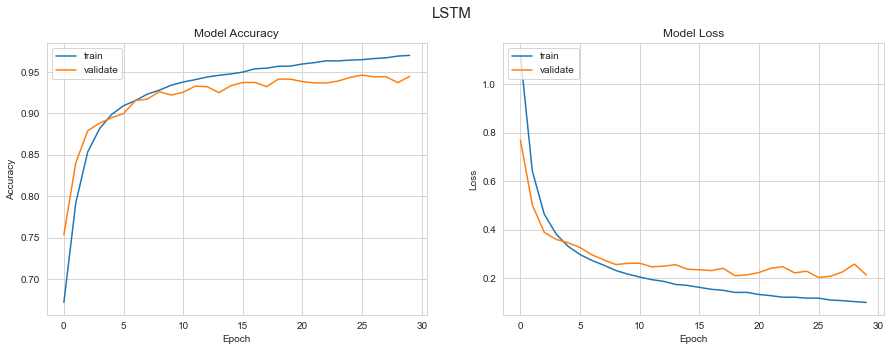

In [30]:
plot_model_history(history_lstm, 'LSTM')

### GRU

In [21]:
model_gru = rnn_network(INPUT_DIM, OUTPUT_DIM, GRU)
model_gru.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 99, 161)]         0         
                                                                 
 conv1d (Conv1D)             (None, 23, 256)           412416    
                                                                 
 b_norm (BatchNormalization)  (None, 23, 256)          1024      
                                                                 
 activation (Activation)     (None, 23, 256)           0         
                                                                 
 dropout_1 (Dropout)         (None, 23, 256)           0         
                                                                 
 rnn_1 (GRU)                 (None, 23, 128)           148224    
                                                                 
 rnn_2 (GRU)                 (None, 128)               99072   

In [22]:
K.clear_session()

In [23]:
history_gru = model_gru.fit(x_train, y_train,
                            batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,
                            validation_data=(x_val, y_val),
                       )

Epoch 1/30
400/400 [==============================] - 113s 259ms/step - loss: 1.0802 - accuracy: 0.6840 - val_loss: 0.5835 - val_accuracy: 0.8083
Epoch 2/30
400/400 [==============================] - 100s 250ms/step - loss: 0.5139 - accuracy: 0.8338 - val_loss: 0.3527 - val_accuracy: 0.8869
Epoch 3/30
400/400 [==============================] - 96s 241ms/step - loss: 0.3752 - accuracy: 0.8811 - val_loss: 0.2954 - val_accuracy: 0.9060
Epoch 4/30
400/400 [==============================] - 102s 254ms/step - loss: 0.3132 - accuracy: 0.9033 - val_loss: 0.2761 - val_accuracy: 0.9139
Epoch 5/30
400/400 [==============================] - 102s 255ms/step - loss: 0.2771 - accuracy: 0.9149 - val_loss: 0.2487 - val_accuracy: 0.9232
Epoch 6/30
400/400 [==============================] - 111s 277ms/step - loss: 0.2483 - accuracy: 0.9252 - val_loss: 0.2361 - val_accuracy: 0.9267
Epoch 7/30
400/400 [==============================] - 98s 245ms/step - loss: 0.2304 - accuracy: 0.9288 - val_loss: 0.2239 - v

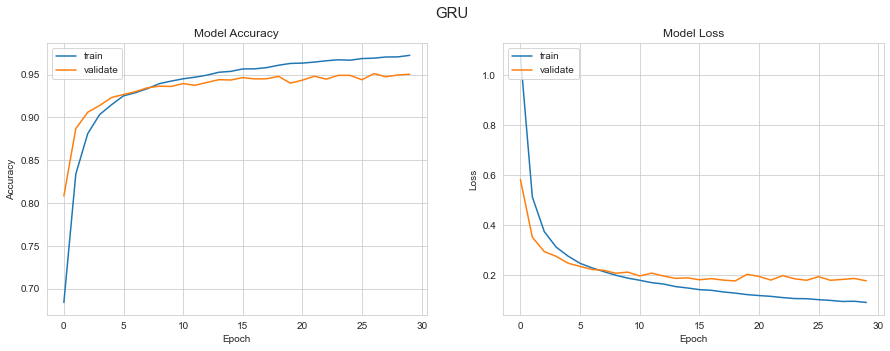

In [29]:
plot_model_history(history_gru, 'GRU')

### Evaluation

In [47]:
y_pred_test_1 = model_simple.predict(x_test)
y_pred_test_classes_1 = np.argmax(y_pred_test_1, axis=-1)

y_pred_test_2 = model_lstm.predict(x_test)
y_pred_test_classes_2 = np.argmax(y_pred_test_2, axis=-1)

y_pred_test_3 = model_gru.predict(x_test)
y_pred_test_classes_3 = np.argmax(y_pred_test_3, axis=-1)

In [51]:
def plot_heatmaps(models_results: list, title: str=None) -> None:
    """
    Plot heatmaps based on the confusion matrices of a given models.

    Args:
        models_results (list): List of confusion matrices of the evaluated models.
        title (str): Title of the plots.
    """
    fig, axes = plt.subplots(1,3,figsize=(18,6))
    models = ['SimpleRNN', 'LSTM', 'GRU']
    for i in range(3):
        sns.heatmap(models_results[i], annot=True, cmap="Blues", ax=axes[i], fmt='d', annot_kws={"size": 12})
        axes[i].set_title(models[i], size=15)
        axes[i].set_xticklabels(axes[i].get_xmajorticklabels(), fontsize = 12)
        axes[i].set_yticklabels(axes[i].get_xmajorticklabels(), fontsize = 12)
        cax = plt.gcf().axes[-1]
        cax.tick_params(labelsize=12)

    plt.tight_layout()
    plt.show()

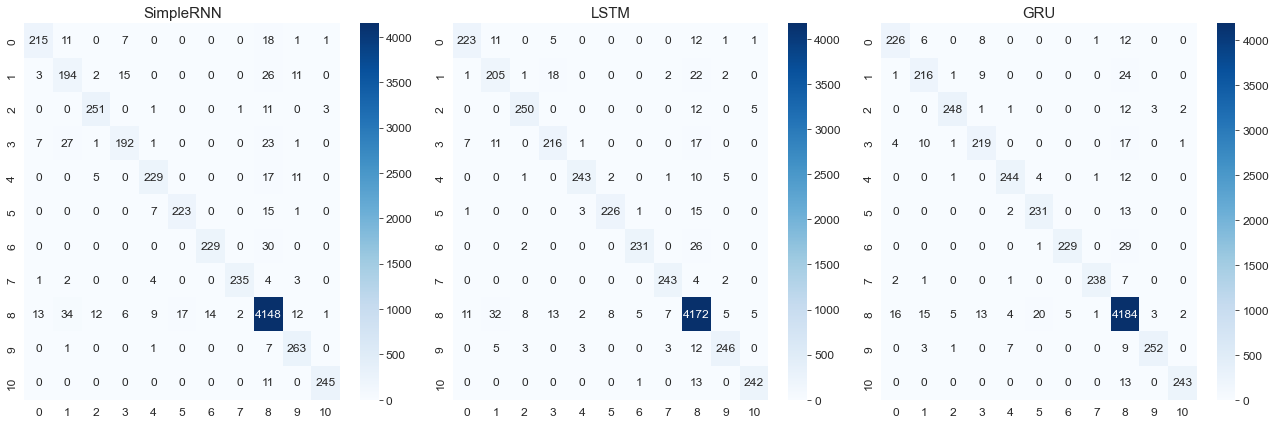

In [56]:
models_results = [pd.DataFrame(confusion_matrix(np.argmax(y_test, axis=-1), y_pred_test_classes_1)),
                  pd.DataFrame(confusion_matrix(np.argmax(y_test, axis=-1), y_pred_test_classes_2)),
                  pd.DataFrame(confusion_matrix(np.argmax(y_test, axis=-1), y_pred_test_classes_3))]
plot_heatmaps(models_results)

(array([ 253.,  251.,  267.,  252.,  262.,  246.,  259.,  249., 4268.,
         528.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

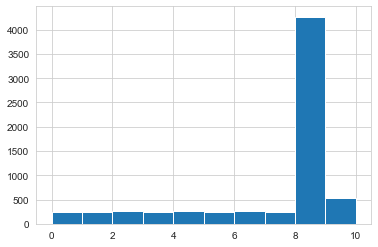

In [61]:
plt.hist(np.argmax(y_test, axis=-1))